In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from tqdm import tqdm
from pycaret.classification import *
from zipfile import ZipFile
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
import random

In [2]:
trn_y_path = "../downloads/train_y_v0.1.0.csv"
trn_x_path = "../downloads/train_X_v0.1.0.zip"
tst_x_path = "../downloads/test_X_v0.1.0.zip"

In [3]:
zipf_train = ZipFile(trn_x_path, 'r')
zipf_test = ZipFile(tst_x_path, 'r')

In [4]:
train_y = pd.read_csv(trn_y_path)

In [5]:
def get_spec(file_name, zipf, interval=None):
    data = pickle.loads(zipf.read(file_name))

    # Extract time (t) and signal (x)
    t = data['t'].astype('timedelta64[s]').astype(int)  # Time in seconds
    x = data['v']  # Signal values

    # Handle duplicate timestamps
    unique_t, unique_indices = np.unique(t, return_index=True)
    unique_x = x[unique_indices]

    # Define the new time grid (300 seconds interval)
    start_time = unique_t.min()
    end_time = unique_t.max()
    new_t = np.arange(start_time, end_time + 1, 300)  # 300s interval

    # Interpolate the signal to the new time grid
    interpolation_function = interp1d(unique_t, unique_x, kind='cubic', fill_value="extrapolate")
    new_x = interpolation_function(new_t)

    x = new_x
    t = new_t

    if interval != None:
        start_point = random.randint(0, len(x) - interval)
        x = x[start_point:start_point+interval]
        t = t[start_point:start_point+interval]
    
    # Compute the sampling interval (average time difference between samples)
    dt = np.mean(np.diff(t))  # Time difference in seconds

    # Compute the sampling frequency
    fs = 1.0 / dt  # Sampling frequency in Hz

    # Compute the spectrogram
    frequencies, times, Sxx = signal.spectrogram(
        x,
        fs=fs,
        window='hann',
        scaling='density',
        mode='magnitude'
    )

    return frequencies, times, Sxx

In [10]:
filename_trn = list(train_y.filename.apply(lambda x: "train_X/" + x))
filename_tst = list(zipf_test.namelist()[1:])

In [16]:
_ = get_spec(filename_trn[0], zipf_train)
_ = get_spec(filename_tst[0], zipf_test)

In [20]:
from concurrent.futures import ProcessPoolExecutor

def process_file_sxx(file_name, zip_path):
    # Each process will open the zip independently
    with ZipFile(zip_path, 'r') as zf:
        _, _, sxx = get_spec(file_name, zf)
    return file_name, sxx

In [22]:
if __name__ == "__main__":
    spec_feat = {}

    # (2) Process test files in parallel
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = executor.map(
            process_file_sxx,               # The function to run
            filename_tst,                   # Argument: file_name
            [tst_x_path] * len(filename_tst)  # Argument: zip_path
        )
        for file_name, sxx in tqdm(futures, total=len(filename_tst)):
            spec_feat[file_name] = sxx

    # (3) Process train files in parallel
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = executor.map(
            process_file_sxx,
            filename_trn,
            [trn_x_path] * len(filename_trn)
        )
        for file_name, sxx in tqdm(futures, total=len(filename_trn)):
            spec_feat[file_name] = sxx

Process SpawnProcess-17:
Traceback (most recent call last):
  File "/Users/joezhao/miniconda3/envs/ddm/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/joezhao/miniconda3/envs/ddm/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/joezhao/miniconda3/envs/ddm/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/joezhao/miniconda3/envs/ddm/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_file_sxx' on <module '__main__' (built-in)>
Process SpawnProcess-18:
Traceback (most recent call last):
  File "/Users/joezhao/miniconda3/envs/ddm/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/joezhao/miniconda3/envs/ddm/lib/python3.9/multiprocessing/process.py", line 

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [18]:
spec_feat = {}
for f_name in tqdm(filename_tst):
    _, _, sxx = get_spec(f_name, zipf_test)
    spec_feat[f_name] = sxx

for f_name in tqdm(filename_trn):
    _, _, sxx = get_spec(f_name, zipf_train)
    spec_feat[f_name] = sxx

  0%|          | 1500/315720 [00:05<20:09, 259.76it/s]


KeyboardInterrupt: 

In [112]:
import random

def get_spec(file_index, zipf, train_y, interval):
    file_name = train_y.filename[file_index]  # Adjust based on your train_y structure
    data = pickle.loads(zipf.read('train_X/' + file_name))

    # Extract time (t) and signal (x)
    t = data['t'].astype('timedelta64[s]').astype(int)  # Time in seconds
    x = data['v']  # Signal values

    # Handle duplicate timestamps
    unique_t, unique_indices = np.unique(t, return_index=True)
    unique_x = x[unique_indices]

    # Define the new time grid (300 seconds interval)
    start_time = unique_t.min()
    end_time = unique_t.max()
    new_t = np.arange(start_time, end_time + 1, 300)  # 300s interval

    # Interpolate the signal to the new time grid
    interpolation_function = interp1d(unique_t, unique_x, kind='cubic', fill_value="extrapolate")
    new_x = interpolation_function(new_t)

    x = new_x
    t = new_t

    start_point = random.randint(0, len(x) - interval)
    x = x[start_point:start_point+interval]
    t = t[start_point:start_point+interval]
    
    print(x.shape, t.shape)
    # Compute the sampling interval (average time difference between samples)
    dt = np.mean(np.diff(t))  # Time difference in seconds

    # Compute the sampling frequency
    fs = 1.0 / dt  # Sampling frequency in Hz

    # Compute the spectrogram
    frequencies, times, Sxx = signal.spectrogram(
        x,
        fs=fs,
        window='hann',
        scaling='density',
        mode='magnitude'
    )

    return frequencies, times, Sxx


In [113]:
times

array([ 38400., 105600., 172800., 240000., 307200., 374400., 441600.])

In [119]:
4030 - 288*6
random.randint(0, 4030 - 288*6)

1393

4030
(1728,) (1728,)
(129, 7)


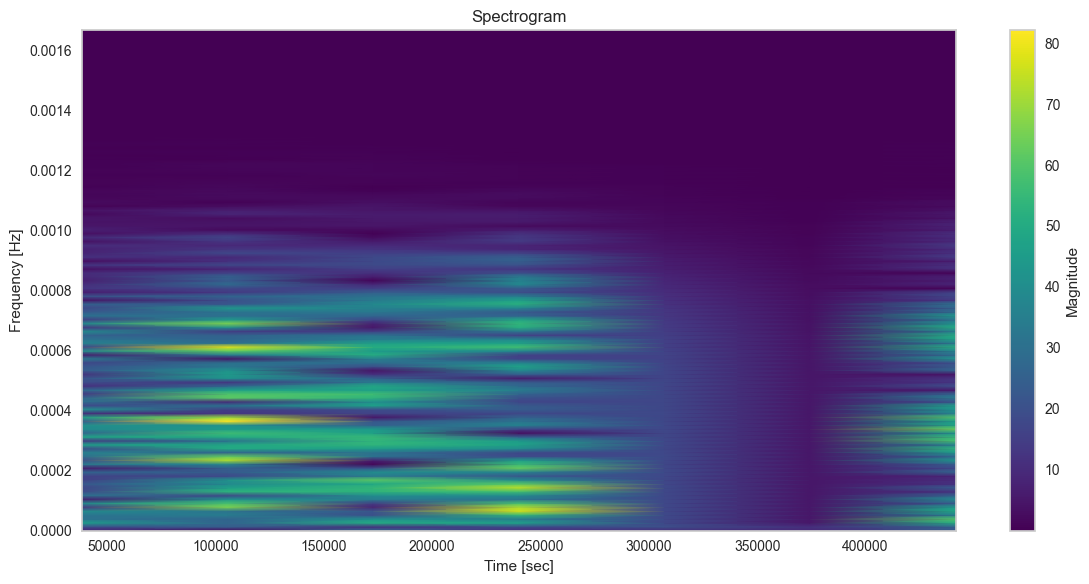

In [115]:
frequencies, times, Sxx = get_spec(3130, zipf, train_y, interval=288*6)
print(Sxx.shape)
plt.figure(figsize=(12, 6))

# Plot using pcolormesh for better performance with large datasets
plt.pcolormesh(times, frequencies, Sxx, shading='gouraud', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()


In [57]:
freq_list = {
    'max': [],
    'mean': [],
    'min': []
}

time_list = {
    'max': [],
    'mean': [],
    'min': []
}

Sxx_list = {
    'max': [],
    'mean': [],
    'min': []
}

def set_v(l, k, v):
    l[k].append(v) 

for i in tqdm(range(2000)):
    frequencies, times, Sxx = get_spec(i, zipf, train_y)
    set_v(freq_list, 'max', frequencies.max())
    set_v(freq_list, 'min', frequencies.min())
    set_v(freq_list, 'mean', frequencies.mean())

    set_v(time_list, 'max', times.max())
    set_v(time_list, 'min', times.min())
    set_v(time_list, 'mean', times.mean())

    set_v(Sxx_list, 'max', Sxx.max())
    set_v(Sxx_list, 'min', Sxx.min())
    set_v(Sxx_list, 'mean', Sxx.mean())


100%|██████████| 2000/2000 [00:07<00:00, 263.54it/s]


In [49]:
check = pd.Series(Sxx_list['mean'])

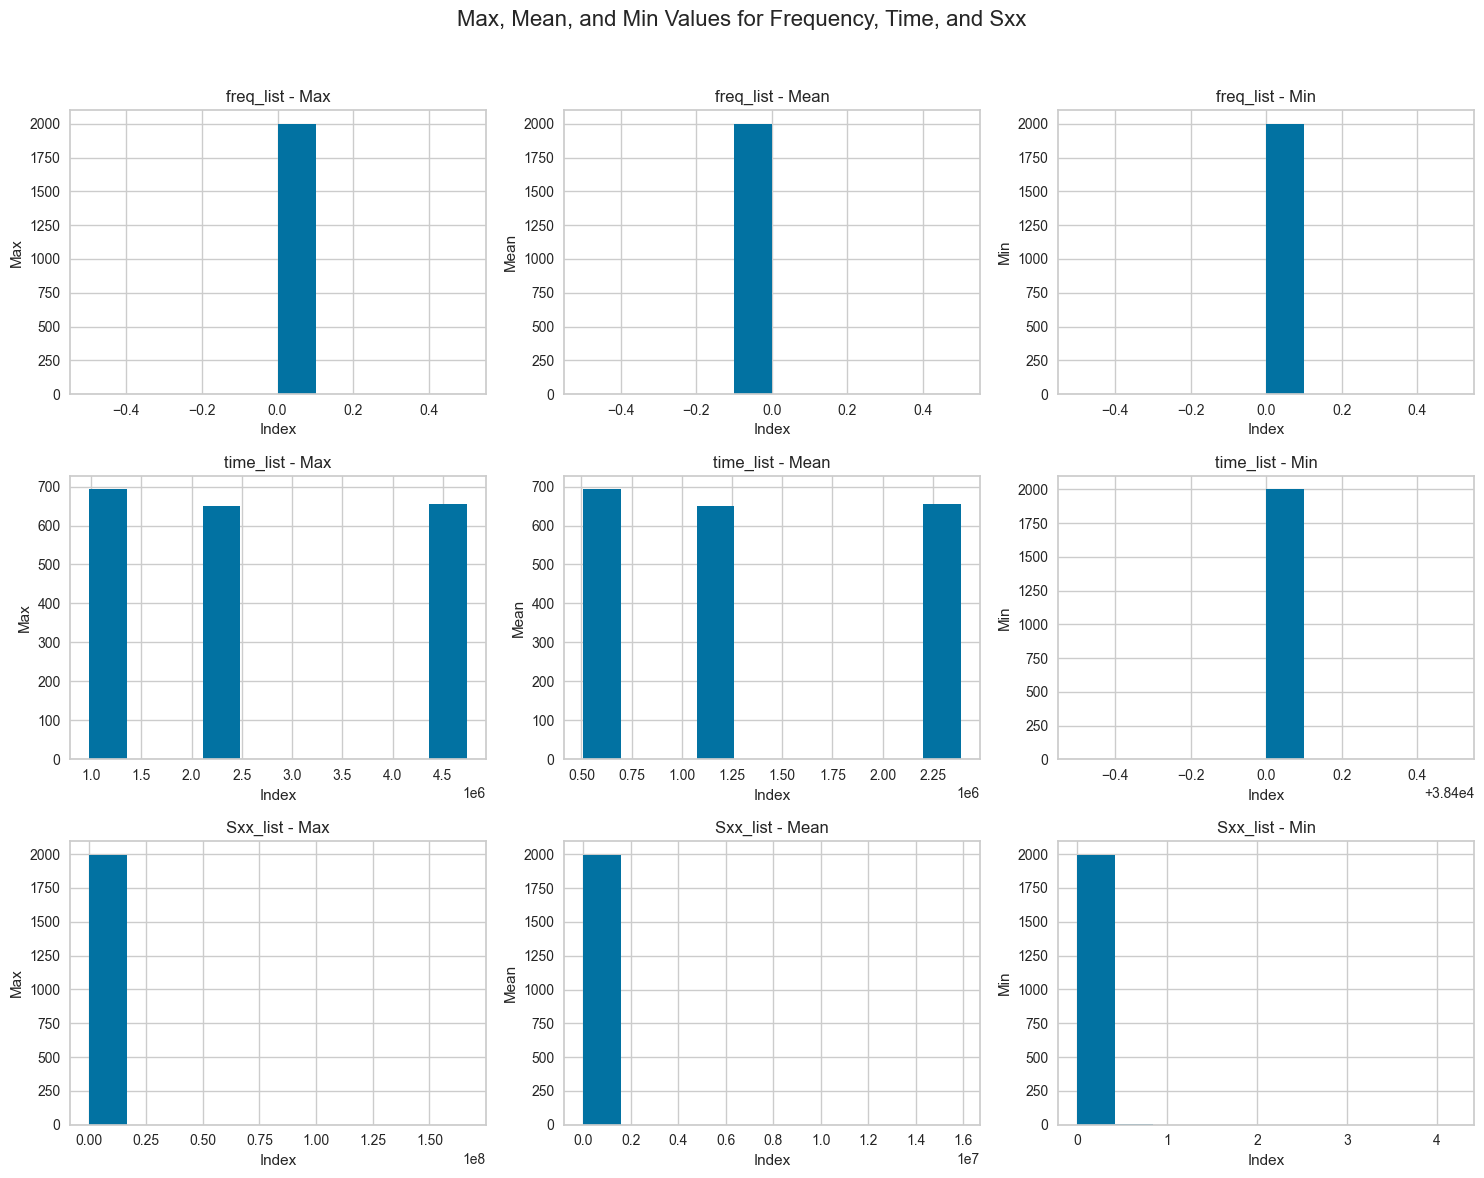

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Max, Mean, and Min Values for Frequency, Time, and Sxx', fontsize=16)

categories = ['freq_list', 'time_list', 'Sxx_list']
titles = ['Max', 'Mean', 'Min']

data_list = [freq_list, time_list, Sxx_list]

# Loop through subplots
for i, (category, data) in enumerate(zip(categories, data_list)):
    for j, stat in enumerate(['max', 'mean', 'min']):
        ax = axes[i, j]
        ax.hist(data[stat])
        ax.set_title(f"{category} - {titles[j]}")
        ax.set_xlabel('Index')
        ax.set_ylabel(stat.capitalize())
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [25]:
import lmdb

In [26]:
import lmdb
import pickle
from tqdm import tqdm

def load_spectrograms_from_lmdb(lmdb_path, filenames, verbose=True):
    """
    Loads spectrograms for a given list of filenames from an LMDB database.

    Args:
        lmdb_path (str): Path to the LMDB directory.
        filenames (list of str): List of filenames to load spectrograms for.
        verbose (bool, optional): If True, displays a progress bar. Defaults to True.

    Returns:
        dict: A dictionary mapping each filename to its spectrogram (numpy.ndarray).
              Filenames not found in the database are skipped.
    """
    spectrograms = {}

    # Open LMDB environment in read-only mode
    env = lmdb.open(
        lmdb_path,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False
    )

    try:
        with env.begin(write=False) as txn:
            if verbose:
                iterator = tqdm(filenames, desc="Loading Spectrograms")
            else:
                iterator = filenames

            for filename in iterator:
                # Encode the filename to bytes, as LMDB keys must be bytes
                key = filename.encode('utf-8')
                value = txn.get(key)

                if value is None:
                    # Handle missing filenames as needed
                    # Option 1: Skip and continue
                    print(f"Warning: Filename '{filename}' not found in LMDB.")
                    continue

                    # Option 2: Alternatively, you can set spectrogram as None or raise an error
                    # spectrograms[filename] = None
                    # raise KeyError(f"Filename '{filename}' not found in LMDB.")

                try:
                    # Deserialize the spectrogram using pickle
                    sxx = pickle.loads(value)
                    spectrograms[filename] = sxx
                except Exception as e:
                    print(f"Error deserializing spectrogram for '{filename}': {e}")
                    # Optionally, handle the error as needed
                    continue

    finally:
        # Ensure the LMDB environment is properly closed
        env.close()

    return spectrograms

In [45]:
d = load_spectrograms_from_lmdb("./spec_feat.lmdb", train_y.filename.apply(lambda x: "train_X/" + x).iloc[0:2560])

Loading Spectrograms: 100%|██████████| 2560/2560 [00:02<00:00, 1279.17it/s]


In [61]:
train_y.filename.apply(lambda x: "train_X/" + x).iloc[0:2560]

0          train_X/train_X0.pkl
1          train_X/train_X1.pkl
2          train_X/train_X2.pkl
3          train_X/train_X3.pkl
4          train_X/train_X4.pkl
                 ...           
2555    train_X/train_X2555.pkl
2556    train_X/train_X2556.pkl
2557    train_X/train_X2557.pkl
2558    train_X/train_X2558.pkl
2559    train_X/train_X2559.pkl
Name: filename, Length: 2560, dtype: object

In [46]:
list(d.values())[4].shape

(129, 71)

In [122]:
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
import pickle
from scipy.interpolate import interp1d
from scipy import signal
import numpy as np
import pandas as pd
import random
from zipfile import ZipFile
import os
import torch
import torch.nn.functional as F

class BrickDataset(Dataset):
    def __init__(
        self,
        zip_path: str,
        feat_path: str,
        label_path: str = None,
        sample_indicies: list = None,
        **kwargs
    ):
        super().__init__(**kwargs)

        zipf = ZipFile(zip_path, 'r')

        # if the dataset has label path (provided training set), get filenames from label file
        if label_path != None:
            label_df = pd.read_csv(label_path)
            filename_list = label_df['filename'].apply(lambda x: "train_X/" + x)
            label = {"train_X/" + rec[0]: rec[1:] for rec in train_y.values}

        # if the dataset does not has label path (provided test set), get filenames from the zip
        else:
            filename_list = zipf.namelist()[1:]

        filename_list = pd.Series(filename_list)
        # if sample indicies provided, only use a part of the dataset
        # Otherwise use the full dataset
        if sample_indicies:
            filename_list = filename_list.iloc[[sample_indicies]]

        filename_list = list(filename_list)

        self.filename_list = filename_list
        self.env = lmdb.open(feat_path, readonly=True, lock=False, readahead=False)

        if label_path != None:
            self.label = {
                f_name: torch.tensor(label[f_name].astype(int))
                for f_name in filename_list
            }
        else:
            self.label = {}
        
    def __len__(self):
        return len(self.filename_list)
    
    def __getitem__(self, index):
        filename = self.filename_list[index]
        label = self.label.get(filename, torch.Tensor([]))

        with self.env.begin(write=False) as txn:
            key = filename.encode('utf-8')
            value = txn.get(key)
            if value is None:
                raise KeyError(f"Filename '{filename}' not found in the database.")
            sxx = pickle.loads(value)
        
        # Convert to tensor
        sxx_tensor = torch.tensor(sxx, dtype=torch.float32)
        
        return sxx_tensor, label

In [123]:
trn_y_path = "../downloads/train_y_v0.1.0.csv"
trn_x_path = "../downloads/train_X_v0.1.0.zip"
tst_x_path = "../downloads/test_X_v0.1.0.zip"

ds = BrickDataset(
    zip_path=trn_x_path,
    feat_path="./spec_feat.lmdb",
    label_path=trn_y_path,
)

In [134]:
from typing import Tuple

def collate_fn(batch, target_dim: Tuple[int, int] = (128, 64)):
    # target_dim max is (129, 71)
    
    # Unzip the batch into features and labels
    features, labels = zip(*batch)
    
    padded_features = []
    target_height, target_width = target_dim  # Target dimensions
    
    for idx, feat in enumerate(features):
        # Ensure the feature is a torch.Tensor
        if not isinstance(feat, torch.Tensor):
            raise TypeError(f"Feature at index {idx} is not a torch.Tensor. Got {type(feat)}")
        
        # Get current dimensions
        current_height, current_width = feat.shape
        
        # Calculate padding sizes
        pad_height = target_height - current_height
        pad_width = target_width - current_width
        
        # Initialize padding for height and width
        # pad should be in the format (pad_left, pad_right, pad_top, pad_bottom)
        pad = (0, pad_width, 0, pad_height)
        
        # If padding is needed
        if pad_height > 0 or pad_width > 0:
            # Apply padding with constant value 0
            padded_feat = F.pad(feat, pad, mode='constant', value=0)
        else:
            # If the feature is larger than target, truncate it
            padded_feat = feat[:target_height, :target_width]
        
        # Ensure the padded feature has the target shape
        assert padded_feat.shape == (target_height, target_width), \
            f"Padded feature has shape {padded_feat.shape}, expected {(target_height, target_width)}"
        
        padded_features.append(padded_feat)
    
    # Stack all padded features into a single tensor
    batch_features = torch.stack(padded_features)
    
    return batch_features, labels

dl = DataLoader(
    dataset=ds,
    batch_size=1024,
    shuffle=True,
    collate_fn=collate_fn
)

In [132]:
for d in tqdm(dl):
    break
    

  0%|          | 0/32 [00:01<?, ?it/s]


In [133]:
# print(d[0].shape, d[1].shape)
d[0].shape

torch.Size([1024, 128, 64])

In [108]:
shape_x = []
shape_y = []
for d in tqdm(dl):
    for sample in d:
        shape_x.append(sample[0].shape[0])
        shape_y.append(sample[0].shape[1])
    break

100%|██████████| 309/309 [06:08<00:00,  1.19s/it]


In [110]:
np.array(shape_x).max()

129

In [135]:
ds.label['train_X/train_X0.pkl'].shape

{'train_X/train_X0.pkl': tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1]),
 'train_X/train_X1.pkl': tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1]),
 'train_X/train_X2.pkl': tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,